In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
data = fetch_covtype();
print(data.data.shape)
print(data.target.shape)
print(data.data)
print(data.target)
type(data.data)
type(data.target)

(581012, 54)
(581012,)
[[2.596e+03 5.100e+01 3.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.590e+03 5.600e+01 2.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.804e+03 1.390e+02 9.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [2.386e+03 1.590e+02 1.700e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.384e+03 1.700e+02 1.500e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.383e+03 1.650e+02 1.300e+01 ... 0.000e+00 0.000e+00 0.000e+00]]
[5 5 2 ... 3 3 3]


numpy.ndarray

# Transformacija ulaznih podataka


Provjera distribucije klasa u skupu podataka:

In [ ]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

class_distribution = df['target'].value_counts()
print(class_distribution)

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: target, dtype: int64


Postoji 7 klasa sa velikim varijacijama u broju uzoraka.

In [ ]:
num_samples = np.min(class_distribution.values)

Za svaku klasu uzimamo `num_samples` broj uzoraka, koji predstavlja najmanji broj uzoraka od svih klasa, kako bi raspodjela bila uniformna.

In [ ]:
classes = np.unique(data.target)
class_subsets_X = []
limited_y = []

for target_class in classes:
    class_mask = (data.target == target_class)
    class_data_X = data.data[class_mask]
    class_data_y = data.target[class_mask]

    if len(class_data_X) > num_samples:
      class_data_X = class_data_X[:num_samples]

    class_subsets_X.append(class_data_X)
    limited_y = np.hstack((limited_y, (data.target[class_mask])[:len(class_data_X)]))

limited_X = np.vstack(class_subsets_X)
print(limited_X.shape)
print(limited_y.shape)
print(limited_X)
print(limited_y)

(19229, 54)
(19229,)
[[2.699e+03 3.470e+02 3.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.739e+03 3.230e+02 2.500e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.696e+03 7.200e+01 2.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [3.256e+03 7.900e+01 1.700e+01 ... 0.000e+00 1.000e+00 0.000e+00]
 [3.249e+03 7.500e+01 1.200e+01 ... 0.000e+00 1.000e+00 0.000e+00]
 [3.244e+03 7.200e+01 8.000e+00 ... 1.000e+00 0.000e+00 0.000e+00]]
[1. 1. 1. ... 7. 7. 7.]


# Podjela na skupove

Inicijalizacija ulaza i labela:

In [ ]:
limited_y = limited_y.reshape(-1, 1)
reduced_data = np.hstack((limited_X, limited_y))
np.random.shuffle(reduced_data)

X = reduced_data[:, :-1]
y = reduced_data[:, -1]
print(X.shape)
print(y.shape)
print(X)
print(y)

(19229, 54)
(19229,)
[[2761.  314.   20. ...    0.    0.    0.]
 [2833.   78.   15. ...    0.    0.    0.]
 [2830.  140.   16. ...    0.    0.    0.]
 ...
 [2703.   47.    8. ...    0.    0.    0.]
 [2076.   27.   21. ...    0.    0.    0.]
 [2912.  252.   10. ...    0.    0.    0.]]
[6. 5. 5. ... 1. 3. 5.]


One-hot encoding y:

In [ ]:
y_one_hot = []

for c in y:
  row = [0 for _ in range(7)]
  row[int(c-1)] = 1
  y_one_hot.append(row)


Normalizacija X:

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X_normalized = scaler.transform(X)

Inicijalizacija trening, testnog i validacionog skupa:

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train_t = torch.tensor(X_train).float()
X_test_t = torch.tensor(X_test).float()
X_val_t = torch.tensor(X_val).float()

In [ ]:
y_train_t = torch.tensor(y_train).float()
y_test_t = torch.tensor(y_test).float()
y_val_t = torch.tensor(y_val).float()

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

In [ ]:
train_loader = DataLoader(train_dataset, 32)
test_loader = DataLoader(test_dataset, 32)
val_loader = DataLoader(val_dataset, 32)

# Model

Definicija modela; Model ima 54 ulaza koji odgovaraju broju atributa uzoraka i 7 izlaza od kojih najveci odredjuje klasu

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(54, 100)
    self.act1 = nn.ReLU()
    self.d1 = nn.Dropout(0.2)
    self.l2 = nn.Linear(100, 150)
    self.act2 = nn.ReLU()
    self.d2 = nn.Dropout(0.3)
    self.l3 = nn.Linear(150, 100)
    self.act3 = nn.ReLU()
    self.l4 = nn.Linear(100, 7)

  def forward(self, x):
    x = self.d1(self.act1(self.l1(x)))
    x = self.d2(self.act2(self.l2(x)))
    x = self.act3(self.l3(x))
    x = self.l4(x)
    return x

In [ ]:
classifier = Classifier()

# Testiranje modela

Testiranje modela nad predvidjenim testnim skupom i graficki prikaz preciznosti i odziva

In [ ]:
loss_fn = nn.CrossEntropyLoss()

def test_model(model, test_loader):
  total_loss = 0
  model.eval()
  predicted_class = []
  expected_class = []

  for X_batch, y_batch in test_loader:
    for X_sample, y_sample in zip(X_batch, y_batch):
      preds = model.forward(X_sample)
      loss = loss_fn(preds, y_sample)
      total_loss += loss.item()
      predicted_class.append(torch.argmax(preds))
      expected_class.append(torch.argmax(y_sample))

  c_matrix = confusion_matrix(expected_class, predicted_class)
  cl_report = classification_report(expected_class, predicted_class)

  plt.figure(figsize=(4,4))
  sns.heatmap(c_matrix, annot=True, fmt='g', vmin=0, cbar=False, cmap='BuPu')
  plt.title("Confusion matrix")
  plt.xlabel("Predicted values")
  plt.ylabel("Actual values")
  plt.show()
  print("Classification report:\n", cl_report)
  print("Average loss: ", total_loss/len(test_loader.dataset))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


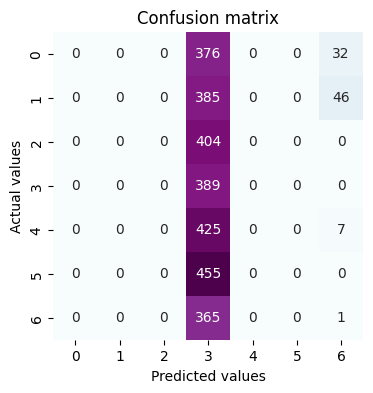

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       408
           1       0.00      0.00      0.00       431
           2       0.00      0.00      0.00       404
           3       0.14      1.00      0.24       389
           4       0.00      0.00      0.00       432
           5       0.00      0.00      0.00       455
           6       0.01      0.00      0.00       366

    accuracy                           0.14      2885
   macro avg       0.02      0.14      0.04      2885
weighted avg       0.02      0.14      0.03      2885

Average loss:  1.9484300499359077


In [ ]:
test_model(classifier, test_loader)

# Treniranje

Treniranje modela sa predvidjenim skupom za trening uz validaciju pri cemu se treniranje zaustavlja ukoliko se greska poveca po treci put zaredom

In [ ]:
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [ ]:
def train_model(epochs, min_loss, patience):

  for i in range(epochs):
    classifier.train()
    for x, y in train_loader:
      preds = classifier(x)
      loss = loss_fn(preds, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    classifier.eval()
    total_loss = 0

    with torch.no_grad():
      for x, y in val_loader:
        preds = classifier(x)
        loss = loss_fn(preds, y)
        total_loss += loss.item()

      average_loss = total_loss/len(val_loader.dataset)

      if(average_loss > min_loss):
        counter+=1
      else:
        min_loss = average_loss
        counter=0

      if(counter >= patience):
        print("Last epoch: ", i)
        return

train_model(100, 10, 3)

Last epoch:  20


Testiranje modela i prikaz rezultata nakon treniranja modela:

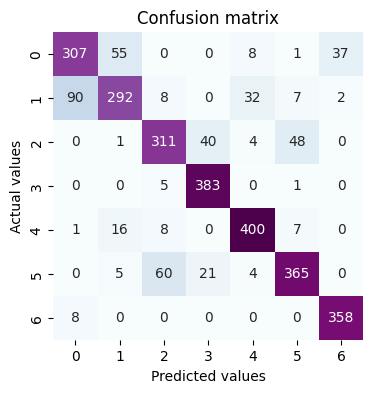

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.75       408
           1       0.79      0.68      0.73       431
           2       0.79      0.77      0.78       404
           3       0.86      0.98      0.92       389
           4       0.89      0.93      0.91       432
           5       0.85      0.80      0.83       455
           6       0.90      0.98      0.94       366

    accuracy                           0.84      2885
   macro avg       0.84      0.84      0.84      2885
weighted avg       0.83      0.84      0.83      2885

Average loss:  0.41311564983418597


In [ ]:
test_model(classifier, test_loader)